In [11]:
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages #reducer function
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from IPython.display import Image, display

import yfinance as yf

In [13]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [14]:
@tool
def get_stock_price(ticker: str) -> str:
    """
    Get the latest stock price for a given ticker symbol.
    Example tickers: AAPL, GOOGL, TSLA, INFY.NS, TCS.NS, RELIANCE.NS
    """
    stock = yf.Ticker(ticker)
    data = stock.history(period="1d")

    if data.empty:
        return f"No data found for {ticker}"

    price = data["Close"].iloc[-1]
    return f"The latest price of {ticker} is {price:.2f}"

In [15]:
tools = [get_stock_price]
llm = init_chat_model("google_genai:gemini-2.5-flash-lite", temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State) -> State:
    ai_msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [ai_msg]}

In [21]:
builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("chatbot", END)
chatGraph = builder.compile()

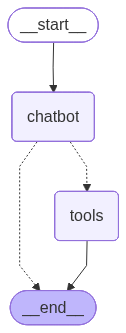

In [22]:
display(Image(chatGraph.get_graph().draw_mermaid_png()))

In [23]:
response = chatGraph.invoke({"messages": [HumanMessage(content="What is the price of TCS.NS?")]})

response["messages"][-1].content

'The latest price of TCS.NS is 2999.10'

In [24]:
response = chatGraph.invoke({"messages": [HumanMessage(content="I want to buy 10 shares of AAPL. And 5 TCS.NS. What's the total cost?")]})

response["messages"][-1].content

'I can help you with that. What is the current price of AAPL and TCS.NS?'